# Stochastic Simulation - Coursework 2023

This assignment has two parts and graded over **100 marks**. Some general remarks:

- The assignment is due on **11 December 2023, 1PM GMT**, to be submitted via Blackboard (see the instructions on the course website).
- You should use this .ipynb file as a skeleton and you should submit a PDF report. Prepare the IPython notebook and export it as a PDF. If you can't export your notebook as PDF, then you can export it as HTML and then use the "Print" feature in browser (Chrome: File -> Print) and choose "Save as PDF". 
- Your PDF should be no longer than 20 pages. But please be concise.
- You can reuse the code from the course material but note that this coursework also requires novel implementations. Try to personalise your code in order to avoid having problems with plagiarism checks. You can use Python's functions for sampling random variables of all distributions of your choice.
- **Please comment your code properly.**

Let us start our code.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(36)

## Q1: Model Selection via Perfect Monte Carlo (40 marks)

Consider the following probabilistic model
\begin{align*}
    p(x) &= \mathcal{N}(x; 5, 0.01), \\
    p(y_i|x) &= \mathcal{N}(y_i; \theta x, 0.05),
\end{align*}
for $i = 1, \ldots, T$ where $y_i$ are conditionally independent given $x$. You are given a dataset (see it on Blackboard) denoted here as $y_{1:T}$ for $T = 100$. As defined in the course, we can find the marginal likelihood as
\begin{align*}
p_\theta(y_{1:T}) = \int p_\theta(y_{1:T}|x) p(x) \mathrm{d} x,
\end{align*}
where we have left $\theta$-dependence in the notation to emphasise that the marginal likelihood is a function of $\theta$.

Given the samples from prior $p(x)$, we can identify our test function above as $\varphi(x) = p_\theta(y_{1:T}|x)$.

**(i)** The first step is to write a log-likelihood function of $y_{1:T}$, i.e., $p_\theta(y_{1:T} | x)$. Note that, this is the joint likelihood of conditionally i.i.d. observations $y_i$ given $x$. This function should take input the data set vector `y` as loaded from `y_perfect_mc.txt` below, $\theta$ (scalar), and $x$ (scalar), and `sig` (likelihood variance which is given as 0.05 in the question but leave it as a variable) values to evaluate the log-likelihood. Note that log-likelihood will be a **sum** in this case, over individual log-likelihoods. **<span style="color:blue">(10 marks)</span>**

In [2]:
# the following line loads y_perfect_mc.txt
y = np.loadtxt('y_perfect_mc.txt')
y = np.array(y, dtype=np.float64)

def log_likelihood(y, x, theta, sig): 
    
    # get the length of y
    T = len(y)
    
    # sum the squared differences (y_i - theta*x)^2 where i = 1, 2, ..., N
    sum_sq_diffs = np.sum((y - theta*x)**2) 
    
    # compute the log likelihood 
    log_lik = -T/2*np.log(2*np.pi*sig) - sum_sq_diffs/(2*sig)
    
    return log_lik  

# evaluate likelihood 
print(log_likelihood(y, 1, 1, 1))
print(log_likelihood(y, 1, 1, 0.1))
print(log_likelihood(y, -1, 2, 0.5))

-9898.905478066723
-98046.88084613331
-28974.21408410411


**(ii)** Write a logsumexp function. Let $\mathbf{v}$ be a vector of log-quantities and assume we need to compute $\log \sum_{i=1}^N \exp(v_i)$ where $\mathbf{v} = (v_1, \ldots, v_N)$. This function is given as
\begin{align*}
\log \sum_{i=1}^N \exp(v_i) = \log \sum_{i=1}^N \exp(v_i - v_{\max}) + v_{\max},
\end{align*}
where $v_{\max} = \max_{i = 1,\ldots,N} v_i$. Implement this as a function which takes a vector of log-values and returns the log of the sum of exponentials of the input values. **<span style="color:blue">(10 marks)</span>**

In [3]:
def logsumexp(v):
    sumexp = np.sum(np.exp(v - max(v)))  # sum exp(v_i - v_max) where i = 1, 2, ..., N
    logsumexp = np.log(sumexp) + max(v)  # log exp(v_i - v_max) and add v_max
    return logsumexp

# evaluate logsumexp function 
print(logsumexp(np.array([1, 2, 3])))
print(logsumexp(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])))
print(logsumexp(np.array([5, 6, 9, 12])))

3.4076059644443806
10.45862974442671
12.051811977232925


**(iii)** Now we are at the stage of implementing the log marginal likelihood estimator. Inspect your estimator as described in Part (i). Its particular form is not implementable without using the trick you have coded in Part (iii). Now, implement a function that returns the **log** of the MC estimator you derived in Part (i). This function will take in

- `y` dataset vector
- $\theta$ parameter (scalar)
- `x_samples` (`np.array` vector) which are $N$ Monte Carlo samples.
- a variance (scalar) variable `sig` for the joint log likelihood $p_\theta(y_{1:T} | x)$ that will be used in `log_likelihood` function (we will set this to 0.05 as given in the question).

**Hint:** Notice that the log of the MC estimator of the marginal likelihood takes the form
\begin{align*}
\log \frac{1}{N} \sum_{i=1}^N p_\theta(y_{1:T} | x^{(i)}),
\end{align*}
as given in the question. You have to use $p_\theta(y_{1:T} | x^{(i)}) = \exp(\log p_\theta(y_{1:T} | x^{(i)}))$ to get a `logsumexp` structure, i.e., $\log$ and $\text{sum}$ (over particles) and $\exp$ of $\log p_\theta(y_{1:T} | x^{(i)})$ where $i = 1, \ldots, N$ and $x^{(i)}$ are the $N$ Monte Carlo samples (do **not** forget $1/N$ term too). Therefore, now use the function of Part (i) to compute $\log p_\theta(y_{1:T} | x^{(i)})$ for every $i = 1,\ldots, N$ and Part (ii) `logsumexp` these values to compute the estimate of log marginal likelihood. **<span style="color:blue">(10 marks)</span>**

In [4]:
def log_marginal_likelihood(y, theta, x_samples, sig): 
    
    # get the sample size
    N = len(x_samples)
    
    # store vector of log likelihood p(y | x_i) for i = 1, ..., N:
    log_lik_x_samples = [log_likelihood(y, x_samples[i], theta, sig) for i in range(N)]
    
    # compute log marginal likelihood
    log_marg_lik = np.log(1/N) + logsumexp(log_lik_x_samples)  # because log(ab) = log(a) + log(b)
    
    return log_marg_lik

# evaluate marginal likelihood 
print(log_marginal_likelihood(y, 1, np.array([-1, 1]), 1))
print(log_marginal_likelihood(y, 1, np.array([-1, 1]), 0.1))
print(log_marginal_likelihood(y, 2, np.array([-1, 1]), 0.5))

-9899.598625247283
-98047.57399331387
-16970.96811085916


**(iv)** We will now try to find the most likely $\theta$. For this part, you will run your `log_marginal_likelihood` function for a range of $\theta$ values. Note that, for every $\theta$ value, you need to sample $N$ new samples from the prior (do not reuse the same samples). Compute your estimator of the $\log \hat{\pi}_{\text{MC}}^N \approx \log p_\theta(y_{1:T})$ for $\theta$-range given below. Plot the log marginal likelihood estimator as a function of $\theta$. **<span style="color:blue">(5 marks)</span>**

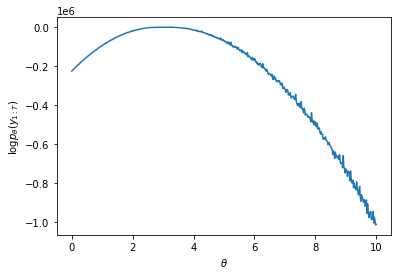

In [5]:
sig = 0.05
sig_prior = 0.01
mu_prior = 5.0

N = 1000
theta_range = np.linspace(0, 10, 500)
log_ml_list = np.array([]) 

for theta in theta_range:
    
    # generate samples from normal distribution with mean mu_prior and variance sig_prior
    x_samples = rng.normal(mu_prior, np.sqrt(sig_prior), N) 
    
    # store value of log marginal likelihood of each sample to log_ml_list
    log_ml_list = np.append(log_ml_list, log_marginal_likelihood(y, theta, x_samples, sig))

# plot results 
plt.plot(theta_range, log_ml_list)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\log p_\theta(y_{1:T})$')
plt.show()

**(v)** Now you have `log_ml_list` variable that corresponds to marginal likelihood values in `theta_range`. Find the $\theta$ value that gives the maximum value in this list and provide your final estimate of most likely $\theta$. **<span style="color:blue">(5 marks)</span>**

In [6]:
# find theta index of max log marginal likelihood value
theta_est_index = np.argmax(log_ml_list)

# rescale according to the linspace
theta_est = theta_range[theta_est_index]

# print your theta estimate
print(theta_est)

2.9859719438877756


## Q2: Posterior sampling (35 marks)

In this question, we will perform posterior sampling for the following model
\begin{align*}
    p(x) &\propto \exp(-x_1^2/10 - x_2^2/10 - 2 (x_2 - x_1^2)^2), \\
    p(y | x) &= \mathcal{N}(y; H x, 0.1)
\end{align*}
where $H = [0, 1]$. In this exercise, we assume that we have observed $y = 2$ and would like to implement a few sampling methods.

Before starting this exercise, please try to understand how the posterior density should look like. The discussion we had during the lecture about Exercise 6.2 (see Panopto if you have not attended) should help you here to understand the posterior density. Note though quantities and various details are **different** here. You should have a good idea about the posterior density before starting this exercise to be able to set the hyperparameters such as the chain-length, proposal noise, and the step-size.

In [3]:
y = np.array([2.0])
sig_lik = 0.1
H = np.array([0, 1])

**(i)** In what follows, you will have to code the log-prior and log-likelihood functions. Do **not** use any library, code the log densities directly. **<span style="color:blue">(5 marks)</span>**

In [6]:
def prior(x): # code banana density for visualisation purposes
    return np.exp(- x[0]**2/10 - x[1]**2/10 - 2*(x[1] - x[0]**2)**2)

def log_prior(x): 
    return np.log(prior(x))

def log_likelihood(y, x, sig_lik): 
    # computed using standard log laws such as log(a^b) = b log(a) and log(ab) = log(a) + log(b)
    return -1/2*np.log(2*np.pi*sig_lik) - (y-H@x)**2/(2*sig_lik)

# evaluate your prior and likelihood 
print(log_prior([0, 1]))
print(log_likelihood(y, np.array([0, 1]), sig_lik))

-2.1
[-4.76764599]


**(ii)** Next, implement **the random walk Metropolis algorithm (RWMH)** for this target. Set an appropriate chain length, proposal variance, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

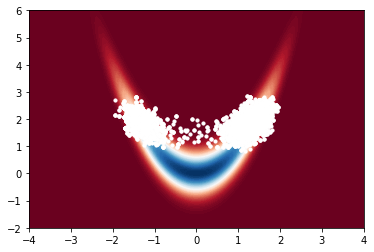

In [39]:
# parameters:
N = 10000  # chain length
prop_sig = 0.1  # proposal variance
burnin = 100  
x = np.zeros((N + 1, 2))  # initialise array to store samples
x[0, :] = [2, 1]  # initial position

# proposal
x_prime = np.random.multivariate_normal(x[0, :], np.sqrt(prop_sig) * np.eye(2))

log_posterior_proposal = log_prior(x_prime)
log_posterior_current = log_prior(x[0, :])

for n in range(1, N + 1):

    # proposal
    x_prime = np.random.multivariate_normal(x[n - 1, :], np.sqrt(prop_sig) * np.eye(2))

    # effectively, log(posterior) = log(prior) + log(likelihood) because the normalising constant vanishes when we compute the acceptance ratio
    log_posterior_proposal = log_prior(x_prime) + log_likelihood(y, x_prime, sig_lik)
    log_posterior_current = log_prior(x[n - 1, :]) + log_likelihood(y, x[n - 1, :], sig_lik)

    # log acceptance ratio
    # random walk proposal is symmetric i.e. q(x'|x_n-1) = q(x_n-1|x') so q cancels out in the acceptance ratio
    log_r = log_posterior_proposal - log_posterior_current

    # draw a sample from U(0, 1) for the transition kernel
    u = np.random.uniform(0, 1)

    # decide whether or not to accept the proposal
    if np.log(u) <= log_r:  # since log is monotone increasing, u <= r is equivalent to log(u) <= log(r)
        x[n, :] = x_prime
        log_posterior_current = log_posterior_proposal
    else:
        x[n, :] = x[n-1, :]

# plot results
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.zeros((100, 100))

for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])

plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.scatter(x[burnin:N, 0], x[burnin:N, 1], s=10, c='white')
plt.show()

**(iii)** Now implement **Metropolis-adjusted Langevin algorithm**. For this, you will need to code the gradient of the density and use it in the proposal as described in the lecture notes. Set an appropriate chain length, step-size, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

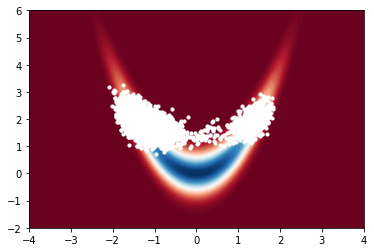

In [42]:
def grad_log_prior(x): 
    # partial derivatives of log of multivariate normal density
    return np.array([-0.2*x[0] + 8*x[0]*(x[1] - x[0]**2), -0.2*x[1] - 4*(x[1] - x[0]**2)])


def grad_log_likelihood(y, x, sig_lik): 
    return np.array([0, (float(y[0]) - H@x)/sig_lik]) 


def log_MALA_kernel(x_new, x_old, gam): 
    # mean of log proposal distribution = previous position + step size * gradient of log(posterior)
    mean = x_old + gam * (grad_log_prior(x_old) + grad_log_likelihood(y, x_old, sig_lik)) 
    
    # we have norm squared because x_new ^T * multiple of identity matrix * x_new = scalar * x_new ^T x_new = scalar * ||x_new||^2
    return - (1/(4 * gam)) * np.linalg.norm(x_new - mean)**2 


def proposal(x_old):
    # sample from multivariate normal distribution centred at the previous position with covariance matrix  2 gam * identity 
    x_new = rng.multivariate_normal(x_old + gam * (grad_log_prior(x_old) + grad_log_likelihood(y, x_old, sig_lik)), 2 * gam * np.eye(2))
    return x_new


# parameters:
gam = 0.01  # step size
N = 10000  # chain length
prop_sig = 0.1  # proposal variance
burnin = 100
x = np.zeros((N+1, 2))  # initialise array to store samples
x[0, :] = [0, 0]  # initial position

accepted_proposals = 0

for n in range(1, N+1):

    x_prime = proposal(x[n-1, :])
    
    # compute log posteriors 
    log_posterior_of_proposal = log_prior(x_prime) + log_likelihood(y, x_prime, sig_lik) 
    log_posterior_of_current = log_prior(x[n-1, :]) + log_likelihood(y, x[n-1, :], sig_lik)
    
    # relabel quantities with more interpretable names
    log_kernel_from_current_to_proposal = log_MALA_kernel(x_prime, x[n-1, :], gam)
    log_kernel_from_proposal_to_current = log_MALA_kernel(x[n-1, :], x_prime, gam)
    
    # compute log acceptance probability 
    log_r = log_posterior_of_proposal + log_kernel_from_proposal_to_current - (log_posterior_of_current + log_kernel_from_current_to_proposal)
    
    # generate U(0, 1) for the transition kernel
    u = rng.uniform(0, 1)
    
    # decide whether or not to accept the proposal
    if np.log(u) <= log_r:  # since log is monotone increasing, u <= r is equivalent to log(u) <= log(r)
        x[n, :] = x_prime   
        accepted_proposals += 1
    else:
        x[n, :] = x[n-1, :]  


# plot results 
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[burnin:N, 0], x[burnin:N, 1], s=10 , c='white')
plt.show()

**(iv)** Next, implement **unadjusted Langevin algorithm**. For this, you will need to code the gradient of the density and use it in the proposal as described in the lecture notes. Set an appropriate chain length, step-size, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

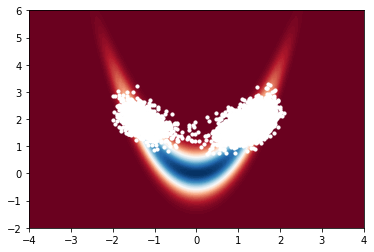

In [41]:
# parameters:
N = 10000  # chain length
gam = 0.01  # step size
x = np.zeros((N+1, 2))  # initialise array to store samples
burnin = 100 
x[0, :] = [-0.5, 1]  # initial position

# ULA iterates
for n in range(1, N+1):
    # discretised SDE
    x[n, :] = x[n-1, :] + gam * (grad_log_prior(x[n-1, :]) + grad_log_likelihood(y, x[n-1, :], sig_lik)) + np.sqrt(2*gam)*rng.multivariate_normal([0, 0], np.eye(2))
    
# plot results 
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[burnin:N, 0], x[burnin:N, 1], s=10 , c='white')
plt.show()

## Q3: Gibbs sampling for 2D posterior (25 marks)

In this question, you will first derive a Gibbs sampler by deriving full conditionals. Then we will describe a method to estimate marginal likelihoods using Gibbs output (and you will be asked to implement the said method given the description).

Consider the following probabilistic model
\begin{align*}
p(x_1) &= \mathcal{N}(x_1; \mu_1, \sigma_1^2), \\
p(x_2) &= \mathcal{N}(x_2; \mu_2, \sigma_2^2), \\
p(y | x_1, x_2) &= \mathcal{N}(y; x_1 + x_2, \sigma_y^2),
\end{align*}
where $y$ is a scalar observation and $x_1, x_2$ are latent variables. This is a simple model where we observe a sum of two random variables and want to construct possible values of $x_1, x_2$ given the observation $y$.

**(i)** Derive the Gibbs sampler for this model, by deriving full conditionals $p(x_1 | x_2, y)$ and $p(x_2 | x_1, y)$ (You can use Example 3.2 but note that this case is different). **<span style="color:blue">(10 marks)</span>**

Applying Bayes' theorem,
\begin{aligned}
p\left(x_1 \mid x_2, y\right) &= \frac{p\left(x_1\right) p\left(x_2, y \mid x_1 \right)}{p\left(x_2, y\right)} \\
&= \frac{p\left(x_1 \cap\left(x_2, y\right)\right)}{p\left(x_2, y\right)} \\
&= \frac{p\left(x_1, x_2, y\right)}{p\left(x_2, y\right)} \\
&= \frac{p\left(y \mid x_1, x_2\right) p\left(x_2 \mid x_1\right) p\left(x_1\right)}{p\left(x_2\right) p\left(y \mid x_2\right)} 
\end{aligned}


where the third equality makes use of the chain rule for conditional probabilities. 

Looking at the expressions for $p(x_1)$ and $p(x_2)$, it is clear that $x_1$ and $x_2$ are independent, so $p(x_2 \mid x_1) = p(x_2)$, and therefore 

\begin{aligned}
\frac{p\left(y \mid x_1, x_2\right) p\left(x_2 \mid x_1\right) p\left(x_1\right)}{p\left(x_2\right) p\left(y \mid x_2\right)} = \frac{p\left(y \mid x_1, x_2\right) p\left(x_1\right)}{p\left(y \mid x_2\right)} \propto p\left(y \mid x_1, x_2\right) p\left(x_1\right)
\end{aligned}

The proportionality arises because we are conditioning on $x_2$ and $y$ so we treat them as constants, and thus $p\left(y \mid x_2\right)$ is effectively a constant w.r.t $x_1$.

We have 

\begin{aligned}
p\left(y \mid x_1, x_2\right) p\left(x_1\right) &\propto \text{exp}\left(-\frac{(y-(x_1+x_2))^2}{2\sigma_y^2}\right)\text{exp}\left(-\frac{(x_1 - \mu_1)^2}{2\sigma_1^2}\right) \\
&\propto \text{exp}\left(-\frac{(y-(x_1+x_2))^2}{2\sigma_y^2} - \frac{(x_1 - \mu_1)^2}{2\sigma_1^2}\right) \\
&\propto \text{exp}\left(-\frac{1}{2 \sigma_y^2 \sigma_1^2}\left(\sigma_1^2\left[y-\left(x_1+x_2\right)\right]^2+\sigma_y^2\left[x_1-\mu_1\right]^2\right)\right) \\
& \propto \text{exp}\left(-\frac{1}{2 \sigma_y^2 \sigma_1^2}\left(\sigma_1^2\left(y^2-2\left(x_1+x_2\right) y+\left(x_1+x_2\right)^2\right)+\sigma_y^2\left(x_1^2-2 \mu_1 x_1+\mu_1^2\right)\right)\right) \\
& \propto \text{exp}\left(-\frac{1}{2 \sigma_y^2 \sigma_1^2}\left(\sigma_1^2 y^2-2 \sigma_1^2 x_1 y-2 \sigma_1^2 x_2 y+\sigma_1^2 x_1^2+2 \sigma_1^2 x_1 x_2+\sigma_1^2 x_2^2+\sigma_y^2 x_1^2-2 \sigma_y^2 \mu_1 x_1+\sigma_y^2 \mu_1^2\right)\right) \\
& \propto \exp\left(-\frac{1}{2 \sigma_y^2 \sigma_1^2}\left(-2 \sigma_1^2 x_1 y + \sigma_1^2 x_1^2 + 2 \sigma_1^2 x_1 x_2 + \sigma_y^2 x_1^2 - 2 \sigma_y^2 \mu_1 x_1\right)\right) \\
& \propto \exp\left(-\frac{1}{2 \sigma_y^2 \sigma_1^2}\left(\left(\sigma_1^2+\sigma_y^2\right) x_1^2-2 \left(\sigma_1^2 y-\sigma_1^2 x_2+\sigma_y^2 \mu_1\right) x_1\right)\right) \\
& \propto \exp\left(-\frac{1}{2 \left(\frac{\sigma_y^2 \sigma_1^2}{\sigma_1^2 + \sigma_y^2}\right)}\left(x_1^2 - 2 \frac{\sigma_1^2 (y - x_2) + \sigma_y^2 \mu_1}{\sigma_1^2 + \sigma_y^2} x_1\right)\right) \\
& \propto \exp\left(-\frac{1}{2 \sigma_A^2}\left(\left(x_1-\mu_A\right)^2-\mu_A^2\right)\right) \text{ where $\sigma_A^2 = \frac{\sigma_y^2 \sigma_1^2}{\sigma_1^2 + \sigma_y^2}$ and $\mu_A = \frac{\sigma_1^2 (y - x_2) + \sigma_y^2 \mu_1}{\sigma_1^2 + \sigma_y^2}$} \\
& \propto \exp\left(-\frac{1}{2 \sigma_A^2}\left(x_1-\mu_A\right)^2\right)
\end{aligned}

So we conclude that $p\left(x_1 \mid x_2, y\right) = N(x_1; \mu_A, \sigma_A^2) = N\left(x_1; \frac{\sigma_1^2 (y - x_2) + \sigma_y^2 \mu_1}{\sigma_1^2 + \sigma_y^2}, \frac{\sigma_y^2 \sigma_1^2}{\sigma_1^2 + \sigma_y^2}\right)$

Taking advantage of the symmetry - more specifically, because $x_1$ and $x_2$ have the same marginal distribution and because $p\left(y \mid x_1, x_2 \right) = N(y; x_1 + x_2, \sigma_y^2) = N(y; x_2 + x_1, \sigma_y^2) = p\left(y \mid x_2, x_1 \right)$, we just need to exchange $x_1$ and $x_2$ to obtain $p\left(x_2 \mid x_1, y\right) = N\left(x_2; \frac{\sigma_2^2 (y - x_1) + \sigma_y^2 \mu_2}{\sigma_2^2 + \sigma_y^2}, \frac{\sigma_y^2 \sigma_2^2}{\sigma_2^2 + \sigma_y^2}\right)$

**(ii)** Let us set $y = 5$, $\mu_1 = 0$, $\mu_2 = 0$, $\sigma_1 = 0.1$, $\sigma_2 = 0.1$, and $\sigma_y = 0.01$.

Implement the Gibbs sampler you derived in Part (i). Set an appropriate chain length and `burnin` value. Plot a scatter plot of your samples (see the visualisation function below). Discuss the result: Why does the posterior look like this? **<span style="color:blue">(15 marks)</span>**

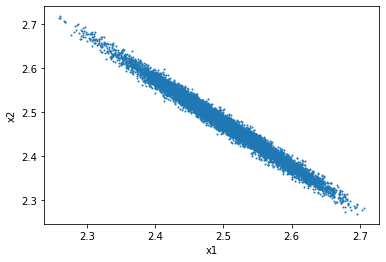

In [27]:
# parameters
y = 5
mu1 = 0
mu2 = 0
sig1 = 0.1
sig2 = 0.1
sig_y = 0.01
N = 10000  # chain length
burnin = 1000
x = np.zeros((N+1, 2))

# mean and standard deviation of full conditional distributions p(x1 | x2, y) (A) and p(x2 | x1, y) (B):

def muA(n):
    return (sig1**2*y - sig1**2*x[n-1, 1] + sig_y**2*mu1)/(sig1**2 + sig_y**2)

def muB(n):
    return (sig2**2*y - sig2**2*x[n, 0] + sig_y**2*mu2)/(sig2**2 + sig_y**2)

sigA = np.sqrt(sig_y**2*sig1**2/(sig_y**2 + sig1**2))
sigB = np.sqrt(sig_y**2*sig2**2/(sig_y**2 + sig2**2))

# initial x1 and x2
x[0, 0] = rng.normal(mu1, sig1)
x[0, 1] = rng.normal(muA(0), sigA)

for n in range(1, N+1): 
    
    # sample from full conditionals. In particular, draw x1 ~ p(x1 | x2, y) and x2 ~ p(x2 | x1, y)
    x[n, 0] = rng.normal(muA(n), sigA)
    x[n, 1] = rng.normal(muB(n), sigB)

x1_chain = x[burnin:N, 0]
x2_chain = x[burnin:N, 1]

# plot results
plt.scatter(x1_chain, x2_chain, s=1)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

<span style="color:red">**Your discussion goes here. (in words).**</span>

The posterior looks like the straight line $x_1 + x_2 = 5$, which makes sense because the conditional density of $y$ given $x_1$ and $x_2$ has mean $x_1 + x_2$ with very little variance so we expect $x_1 + x_2 \approx 5$.

The data points become more concentrated towards the middle, and indeed, the algorithm converges to roughly $(2.5, 2.5)$. The reason is that, if without loss of generality, we assume $x_1$ starts off small, e.g., at 0, then to get $x_2 \approx E(X_2)$ (approximate since $\text{Var}(X_1)$ is very small), we scale $5 - x_1$ by $\frac{100}{101}$, and this scaling shrinks $5 - x_1$ (which is currently just under 5) more in absolute terms than it shrinks $5 - x_2$ (which is currently still close to 0). So, $x_1$ will shrink rapidly, but the shrinking effect becomes weaker as $x_2$ decreases.

The difference between 5 and the new $x_1$ is larger than the difference between 5 and the previous $x_1$, which means that $x_1$ will increase because the $\frac{100}{101}$ makes a negligible difference to $x_1$ since $x_1$ is still small. This process repeats, and $x_1$ and $x_2$ converge to $(x^*, x^*)$, where $(x^*, x^*)$ satisfies $x^* = \frac{100}{101} (5 - x^*)$, and solving this equation, we find that $x^*$ is just under 2.5.
